[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Harvard-CS1090/2026_CS1090B_public/blob/main/sec03/cs1090b_sec03_solutions.ipynb)

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png">

# CS1090B Section 3: Regularization and Data Augmentation

**Harvard University**<br/>
**Spring 2026**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Gumb<br/>

## Overview

In this section, we explore regularization and data augmentation - two strategies for improving generalization in neural networks.

- **Part 1** uses a synthetic regression task to demonstrate overfitting and then applies five regularization methods side-by-side: early stopping, L1/L2 weight penalties, dropout, batch normalization, and Gaussian noise augmentation.
- **Part 2** shifts to image classification on Fashion-MNIST, where we build an MLP classifier, observe overfitting with limited data, and use image-based data augmentation (flips, rotations, noise) to improve generalization.
- The **Team Activity** challenges you to combine regularization and augmentation strategies to push validation accuracy higher.

## Setup: Download Data

In [1]:
# Environment detection and setup
import os
import subprocess
import sys
import shutil

# Define the zip file URL and expected directories
assets_zip_url = "https://github.com/Harvard-CS1090/2026_CS1090B_public/raw/main/sec03/notebook_assets.zip"

assets_zip_name = "notebook_assets.zip"
expected_dirs = ["data", "fig"]

# Check if required directories already exist
all_dirs_exist = all(os.path.isdir(d) for d in expected_dirs)

if all_dirs_exist:
    print("Required directories already exist. Skipping download.")
else:
    print(f"Downloading {assets_zip_name} from GitHub...")
    
    # Use wget in Colab, or urllib for local
    try:
        if 'google.colab' in sys.modules:
            subprocess.run(['wget', '-q', assets_zip_url], check=True)
        else:
            import urllib.request
            urllib.request.urlretrieve(assets_zip_url, assets_zip_name)
        print(f"Downloaded {assets_zip_name}.")
        
        # Unzip the file
        import zipfile
        with zipfile.ZipFile(assets_zip_name, 'r') as zip_ref:
            zip_ref.extractall('.')
        print(f"Extracted {assets_zip_name}.")
        
        # Clean up the zip file
        os.remove(assets_zip_name)
        print(f"Removed {assets_zip_name}.")
        
        # Remove __MACOSX folder if it exists
        if os.path.isdir('__MACOSX'):
            shutil.rmtree('__MACOSX')
            print("Removed __MACOSX folder.")
        
    except Exception as e:
        print(f"Error during setup: {e}", file=sys.stderr)

print("Setup complete!")

Required directories already exist. Skipping download.
Setup complete!


## Part 1: Regularization for Regression

When a model fits the training data too closely - capturing noise rather than the underlying pattern - it **overfits**, performing well on training examples but poorly on unseen data. Regularization techniques address this by constraining the model in various ways.

In this section, we'll intentionally overfit a neural network on a regression task, then apply five regularization techniques to combat it: early stopping, L1/L2 weight penalties, dropout, batch normalization, and data augmentation via Gaussian noise. We'll compare how each method affects the training and validation loss curves.

In [2]:
import copy
import os
import random as rn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torchvision import datasets, transforms 

sns.set_style('whitegrid')

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Reproducibility
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(109)
rn.seed(109)
torch.manual_seed(109);

Using device: cpu


### A Note on GPU Device Management

This notebook is configured to use a GPU when available (`device = 'cuda'`), falling back to CPU otherwise. Working with GPUs in PyTorch requires explicitly moving data and models to the same device. Here's the pattern you'll see throughout:

**1. Model to device** — `model.to(device)` moves all model parameters (weights, biases, BatchNorm statistics) to the GPU. This only needs to be done once after creating the model.

**2. Batches to device** — Inside the training loop, each mini-batch must also be moved: `xb = xb.to(device)` and `yb = yb.to(device)`. DataLoaders return CPU tensors by default, so this transfer happens every iteration. If the model is on GPU but the data is on CPU (or vice versa), PyTorch will raise a runtime error.

**3. Getting results back for evaluation** — There are two separate concerns when extracting values from PyTorch tensors:

- **Computation graph**: Tensors produced during a forward pass track operations for automatic differentiation (regardless of whether they're on CPU or GPU). To disconnect from this graph, either wrap code in `torch.no_grad()` (prevents tracking entirely — used in eval loops) or call `.detach()` on individual tensors.

- **Device transfer**: GPU tensors can't be converted to NumPy arrays directly — they must first move to CPU via `.cpu()`.

In practice you'll see two patterns in this notebook:
- **Scalars** (losses, accuracy counts): use `.item()` to extract a Python number — this handles both detaching and device transfer in one call. Example from the training loop: `loss.item()`, `(preds == yb).sum().item()`.
- **Full tensors** (predictions for plotting): use `.detach().cpu().numpy()` to get a NumPy array. Example from `plot_predictions`: `preds = model(x_tensor).detach().cpu().numpy()`. Inside a `torch.no_grad()` block the `.detach()` is technically redundant, but it's common practice to include it for safety.

In short: **model and data must live on the same device**, and **results must come back to CPU** before you can use them with non-PyTorch libraries like NumPy or matplotlib.

In [3]:
# Load the Lorentz dataset

df = pd.read_csv('data/lorentz_noise_set2.csv')
df = df.sample(frac=1, random_state=109).reset_index(drop=True)

# Split first to avoid leakage, then fit scaler on training data only
x_train, x_val, y_train, y_val = train_test_split(
    df['x'],
    df['y'],
    train_size=0.7,
    random_state=109
)

scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train.to_frame()).ravel()
x_val_std = scaler.transform(x_val.to_frame()).ravel()


**Dataset:** We're using a synthetic dataset based on a Lorentz curve - a peaked, bell-shaped function that's tricky to fit. The exact physics doesn't matter here; what matters is that the relationship between input and output is nonlinear and noisy, making it a good testbed for overfitting.

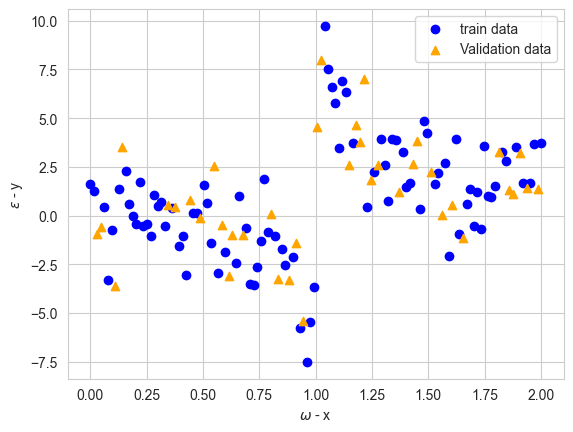

In [4]:
def plot_lorentz(df, idx, ax=None):
    if ax is None:
        ax = plt.gca()
    train_mask = np.ones(df.shape[0], dtype=bool)
    train_mask[idx] = False
    ax.scatter(df.x[train_mask], df.y[train_mask], c='b', label='train data')
    ax.scatter(df.x[~train_mask], df.y[~train_mask], c='orange', marker='^', label='Validation data')
    ax.set_xlabel(r'$\omega$ - x')
    ax.set_ylabel(r'$\epsilon$ - y')
    ax.legend()

plot_lorentz(df, idx=x_val.index)

We will start with a small neural network and intentionally overfit. Below we define a flexible `RegressionMLP` model class and reusable training/plotting utilities that we'll use throughout Part 1 to compare different regularization strategies.

In [5]:
# This class will be utilized later when we add Gaussian noise as a model layer.
class GaussianNoise(nn.Module):
    def __init__(self, stddev):
        super().__init__()
        self.stddev = stddev

    def forward(self, x):
        if self.training and self.stddev > 0:
            noise = torch.randn_like(x) * self.stddev
            return x + noise
        return x

In [6]:
class RegressionMLP(nn.Module):
    def __init__(self, input_dim=1, hidden_sizes=(64, 128), dropout=0.0, use_batchnorm=False, noise_std=0.0):
        super().__init__()
        layers = []
        if noise_std > 0:
            layers.append(GaussianNoise(noise_std))
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [7]:
def train_regression(model, train_loader, val_loader, optimizer, criterion, epochs=200, l1_lambda=0.0, early_stopping=None):
    history = {'loss': [], 'val_loss': []}
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            preds = model(xb).squeeze(1)
            loss = criterion(preds, yb)
            if l1_lambda > 0:
                # L1 penalty on weights only (not biases) — standard convention
                l1_penalty = sum(p.abs().sum() for n, p in model.named_parameters() if 'weight' in n)
                loss = loss + l1_lambda * l1_penalty
            loss.backward()
            optimizer.step()
            # Note: when l1_lambda > 0, train_loss includes the L1 penalty
            # while val_loss below is pure MSE, so the two curves aren't
            # directly comparable for L1 runs.
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                preds = model(xb).squeeze(1)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if early_stopping and early_stopping.step(val_loss, model):
            break

    if early_stopping:
        early_stopping.restore(model)

    return history


def plot_history(history, title=None, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(history['loss'], label='train')
    ax.plot(history['val_loss'], label='validation')
    ax.set_xlabel('epoch')
    ax.set_ylabel('MSE')
    best_loss = np.nanmin(history['val_loss'])
    ax.axvline(np.nanargmin(history['val_loss']), c='k', ls='--', label=f'best val loss = {best_loss:.2f}')
    ax.legend()
    if title:
        ax.set_title(title)

In [8]:
# Prepare tensors and loaders

x_train_t = torch.tensor(x_train_std, dtype=torch.float32).unsqueeze(1).to(device)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).to(device)
x_val_t = torch.tensor(x_val_std, dtype=torch.float32).unsqueeze(1).to(device)
y_val_t = torch.tensor(y_val.values, dtype=torch.float32).to(device)

train_ds = torch.utils.data.TensorDataset(x_train_t, y_train_t)
val_ds = torch.utils.data.TensorDataset(x_val_t, y_val_t)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False)


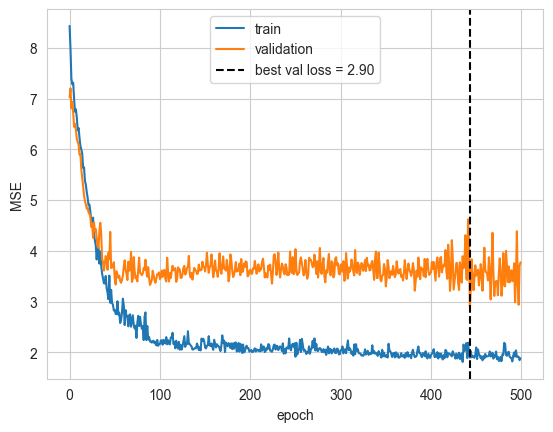

In [9]:
# Baseline model (intentionally overfit)
torch.manual_seed(109)
model_base = RegressionMLP().to(device)
optimizer = optim.Adam(model_base.parameters(), lr=0.01)
criterion = nn.MSELoss()

history_base = train_regression(model_base, train_loader, val_loader, optimizer, criterion, epochs=500)
plot_history(history_base)

> **❓ Question 1: Diagnosing Overfitting**
>
> 1. What do you notice about the gap between training and validation loss as epochs increase?
> 2. Why does the validation loss start to increase even as training loss continues to decrease?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. The gap between training and validation loss grows larger as epochs increase. Early in training, both losses decrease together. But after some point, training loss continues to fall while validation loss levels off and then starts to rise - the curves diverge.
>
> 2. The model is memorizing the training data, including its noise, rather than learning the true underlying pattern. As training continues, the network fits the training points more and more precisely (reducing training loss), but these overly specific fits don't generalize to the validation data. The validation loss rises because the model's predictions become tuned to quirks of the training set that don't exist in the validation set.

</details>

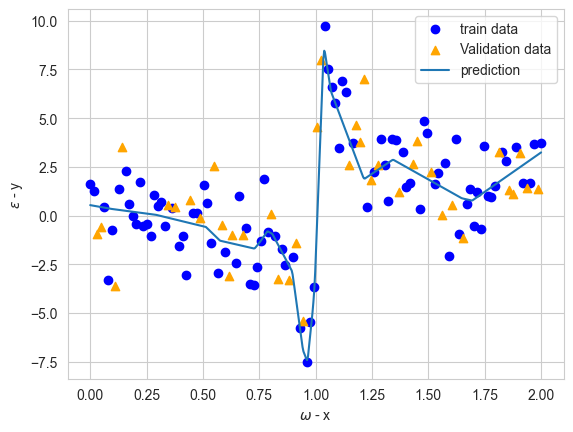

In [10]:
# Plot the overfit predictions
plot_lorentz(df, idx=x_val.index)

def plot_predictions(model):
    model.eval()
    x_lin = np.linspace(df.x.min(), df.x.max(), 500).reshape(-1, 1)
    x_lin_std = scaler.transform(pd.DataFrame(x_lin, columns=['x'])) 
    with torch.no_grad():
        x_tensor = torch.tensor(x_lin_std, dtype=torch.float32).to(device)
        preds = model(x_tensor).detach().cpu().numpy()
    ax = plt.gca()
    ax.plot(x_lin, preds, label='prediction')                                                                                 
    ax.legend();  

plot_predictions(model_base)

### Early Stopping

Early stopping monitors validation loss during training and halts the process when performance stops improving. The idea is simple: as training continues, the model begins to memorize noise in the training data, causing validation loss to rise even as training loss keeps falling. By saving the best model and stopping once validation loss hasn't improved for a set number of epochs (*patience*), we get a model that generalizes better without needing to tune a regularization hyperparameter directly.

In [11]:
class EarlyStopping:
    def __init__(self, patience=50, min_delta=0.0, restore_best=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best = restore_best
        self.best_loss = np.inf
        self.best_state = None
        self.counter = 0

    def step(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best:
                self.best_state = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
        return self.counter >= self.patience

    def restore(self, model):
        if self.restore_best and self.best_state is not None:
            model.load_state_dict(self.best_state)

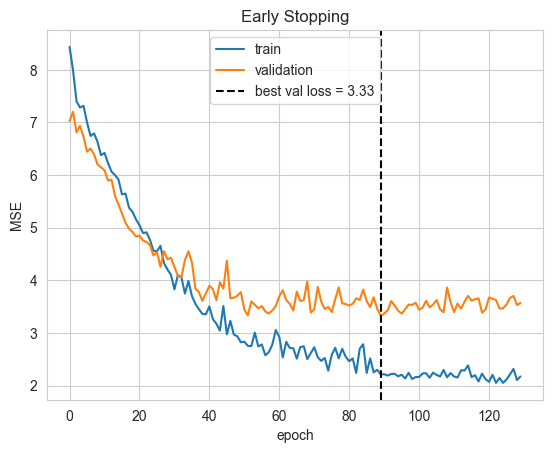

In [12]:
# Early stopping setup
# patience=40: allow 40 epochs without improvement before stopping.
# Too low and training halts prematurely; too high and we waste epochs overfitting.
torch.manual_seed(109)
early_stop = EarlyStopping(patience=40, restore_best=True)
model_es = RegressionMLP().to(device)
optimizer = optim.Adam(model_es.parameters(), lr=0.01)

history_es = train_regression(
    model_es,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=1000,
    early_stopping=early_stop
)
plot_history(history_es, title='Early Stopping')

### Weight Decay (L2) and L1 Regularization

Weight penalties add a cost to having large weights, discouraging the model from fitting noise. **L2 regularization** (weight decay) adds $\lambda \sum w^2$ to the loss, which shrinks all weights toward zero but rarely makes them exactly zero. **L1 regularization** adds $\lambda \sum |w|$ to the loss, which encourages *sparsity* - pushing many weights to exactly zero while keeping a few large ones. In practice, L2 produces smoother models while L1 can act as a form of feature selection.

**From Lecture 4:** L2 regularization shrinks all weights uniformly toward zero, while L1 encourages sparsity by pushing some weights to exactly zero.

<img src="./fig/lec04_l1_vs_l2_regularization.png" width="800">

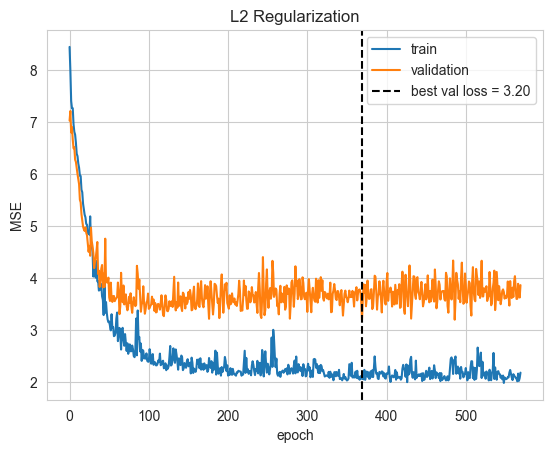

In [13]:
# L2 regularization via weight_decay (applied to weights only, not biases)
# weight_decay=0.005: controls the strength of the L2 penalty.
# Larger values shrink weights more aggressively (smoother model, risk underfitting);
# smaller values give weaker regularization (closer to baseline, risk overfitting).
torch.manual_seed(109)
model_l2 = RegressionMLP().to(device)
optimizer = optim.Adam([
    {'params': [p for n, p in model_l2.named_parameters() if 'weight' in n], 'weight_decay': 0.005},
    {'params': [p for n, p in model_l2.named_parameters() if 'bias' in n], 'weight_decay': 0.0}
], lr=0.01)

history_l2 = train_regression(
    model_l2,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=1500,
    early_stopping=EarlyStopping(patience=200)
)
plot_history(history_l2, title='L2 Regularization')

**Note:** PyTorch also provides `torch.optim.AdamW`, which applies weight decay *directly* to the weights rather than through the gradient. In standard `Adam`, the penalty gets scaled down by the adaptive learning rate, weakening it for frequently-updated parameters. `AdamW` avoids this and is preferred in modern practice (e.g., transformer fine-tuning). For this small example the difference is negligible.

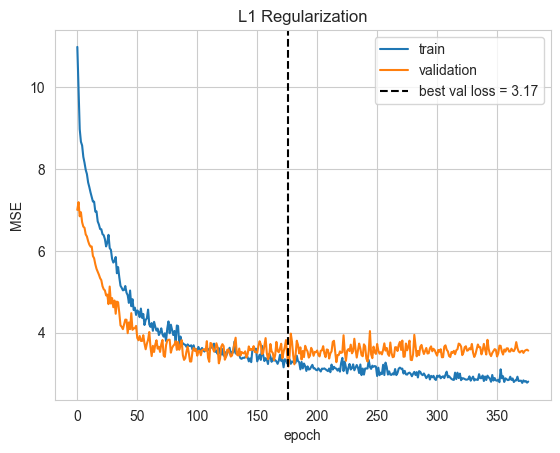

In [14]:
# L1 regularization via explicit penalty
# l1_lambda=0.005: controls sparsity pressure.
# Larger values push more weights to exactly zero (sparser model);
# smaller values allow more non-zero weights (less feature selection).
torch.manual_seed(109)
model_l1 = RegressionMLP().to(device)
optimizer = optim.Adam(model_l1.parameters(), lr=0.01)

history_l1 = train_regression(
    model_l1,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=1500,
    l1_lambda=0.005,
    early_stopping=EarlyStopping(patience=200)
)
plot_history(history_l1, title='L1 Regularization')

> **❓ Question 2: L1 vs L2**
>
> 1. Which penalty tends to push more weights toward zero?
> 2. How might that affect model complexity and interpretability?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. **L1 regularization** tends to push more weights to exactly zero. While L2 shrinks all weights toward zero proportionally (but rarely makes them exactly zero), L1's gradient is constant regardless of weight magnitude, which drives small weights all the way to zero. This produces **sparse** weight matrices.
>
> 2. Sparsity reduces model complexity by effectively removing connections — neurons with all-zero incoming weights contribute nothing to the output. This can improve **interpretability**: if only a few input features have non-zero weights, you can identify which features the model considers important. L1 acts as a form of automatic feature selection. L2, by contrast, keeps all features active (just with smaller weights), which may yield smoother predictions but offers less insight into feature importance.

</details>

### Dropout

Dropout randomly zeroes a fraction of neuron activations during each training step, forcing the network to not rely on any single neuron. This acts as an implicit ensemble — on each forward pass, a different "thinned" subnetwork is active, and the final model approximates an average over all these subnetworks. At evaluation time, dropout is turned off and all neurons are active (with outputs scaled accordingly). The `dropout` parameter controls what fraction of activations are dropped (e.g., 0.3 means 30% are zeroed).

**From Lecture 4:** Dropout randomly "drops" neurons during training, forcing the network to learn redundant representations and reducing co-adaptation between neurons.

<img src="./fig/lec04_dropout_mechanism.png" width="800">

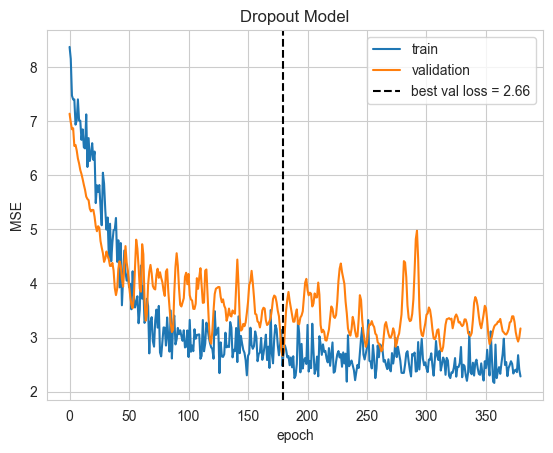

In [15]:
# dropout=0.3: randomly zero 30% of activations each forward pass.
# Higher dropout (e.g., 0.5) gives stronger regularization but may slow convergence;
# lower dropout (e.g., 0.1) has a milder effect.
torch.manual_seed(109)
model_dropout = RegressionMLP(dropout=0.3).to(device)
optimizer = optim.Adam(model_dropout.parameters(), lr=0.01)

history_dropout = train_regression(
    model_dropout,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=1500,
    early_stopping=EarlyStopping(patience=200)
)
plot_history(history_dropout, title='Dropout Model')

### Batch Normalization

Batch normalization normalizes each layer's pre-activations to zero mean and unit variance (computed per mini-batch), then applies a learnable scale and shift. This stabilizes the distribution of inputs to each layer during training, which helps with optimization - allowing higher learning rates and reducing sensitivity to initialization. While not designed as a regularizer, the noise introduced by batch level statistics acts as a mild regularizer in practice.

**Important caveat:** BatchNorm is primarily an **optimization technique**, not a regularizer. It shines in deep networks trained on large datasets with large batch sizes, where the mini-batch statistics are reliable estimates of the true distribution. On small datasets with small batches (like ours), those statistics are noisy, and the normalization can hurt more than it helps — as we'll see below. 

BatchNorm can be more effective with larger datasets and batch sizes. In Part 2 we only use a small subset (1,200 samples), so the batch statistics can still be noisy.


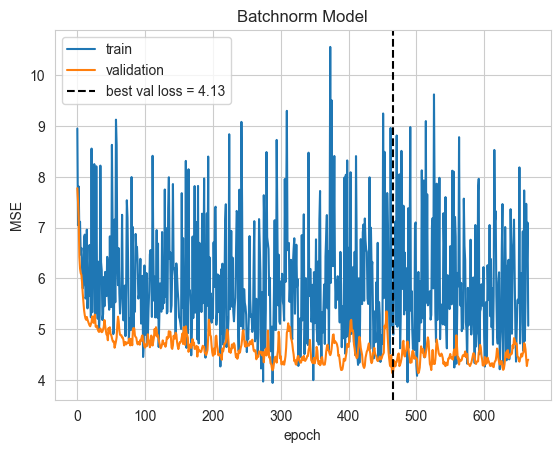

In [16]:
# Same architecture as baseline, but with BatchNorm added.
# No dropout — we want to isolate BatchNorm's effect.
torch.manual_seed(109)
model_bn = RegressionMLP(hidden_sizes=(64, 128), use_batchnorm=True).to(device)
optimizer = optim.Adam(model_bn.parameters(), lr=0.01)

history_bn = train_regression(
    model_bn,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=2000,
    early_stopping=EarlyStopping(patience=200)
)
plot_history(history_bn, title='Batchnorm Model')

> **❓ Question 3: Batch Normalization**
>
> 1. Why does BatchNorm underperform on this small regression task compared to the other regularization methods?
> 2. In what kinds of settings (dataset size, network depth, batch size) would you expect BatchNorm to be more effective?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. BatchNorm is primarily an **optimization technique**, not a regularizer. It normalizes activations using statistics computed from the current mini-batch. With our small dataset and small batch size (32 samples per batch from ~100 training points), these batch statistics are noisy estimates of the true data distribution. This noise can destabilize training rather than help it. Additionally, BatchNorm's mild regularization effect (from the stochastic batch statistics) is weaker than explicit regularizers like dropout or weight decay for preventing overfitting.
>
> 2. BatchNorm excels in settings with: (1) **large datasets** where batch statistics reliably approximate the full data distribution; (2) **deep networks** where it prevents vanishing/exploding gradients and allows higher learning rates; (3) **larger batch sizes** (64+) that give stable statistics. In Part 2 with Fashion-MNIST (1,200 training samples, deeper network), BatchNorm works well because there's more data per class and the architecture benefits from stable activations across multiple layers.

</details>

### Data Augmentation with Gaussian Noise

Adding random noise to inputs during training is a simple form of data augmentation that acts as a regularizer. Each time the model sees a training example, it sees a slightly perturbed version, which prevents it from memorizing exact input-output mappings. The noise is only applied during training - at evaluation time, the original clean inputs are used. This is especially useful when the dataset is small and collecting more data isn't feasible.

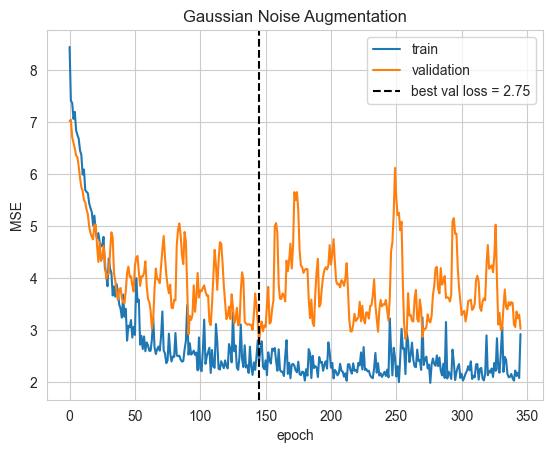

In [17]:
# noise_std=0.02: add Gaussian noise with std=0.02 to inputs during training.
# Larger noise acts as stronger regularization but can obscure the signal;
# smaller noise has a subtler effect. The right scale depends on the input range
# (here inputs are standardized, so 0.02 is a small perturbation).
torch.manual_seed(109)
model_noise = RegressionMLP(noise_std=0.02).to(device)
optimizer = optim.Adam(model_noise.parameters(), lr=0.01)

history_noise = train_regression(
    model_noise,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=1500,
    early_stopping=EarlyStopping(patience=200)
)
plot_history(history_noise, title='Gaussian Noise Augmentation')

### Comparison of Regularization Techniques

Let's compare all the approaches we've tried. For each method we report the **best validation MSE** (primary metric: how well does it generalize?) and the **train-val gap at that epoch** (how much is it overfitting at its best point?). The ideal is low val MSE *and* a small gap - a small gap alone isn't enough if the model isn't fitting the data well.

Method               Best Val MSE  Train at Best      Gap
----------------------------------------------------------
Baseline                   2.9004         1.8921   1.0083
Early Stopping             3.3277         2.2134   1.1144
L2 (weight decay)          3.2012         2.0678   1.1334
L1                         3.1678         3.3631  -0.1952
Dropout                    2.6616         2.4750   0.1866
BatchNorm                  4.1300         5.0893  -0.9594
Gaussian Noise             2.7494         2.3905   0.3589


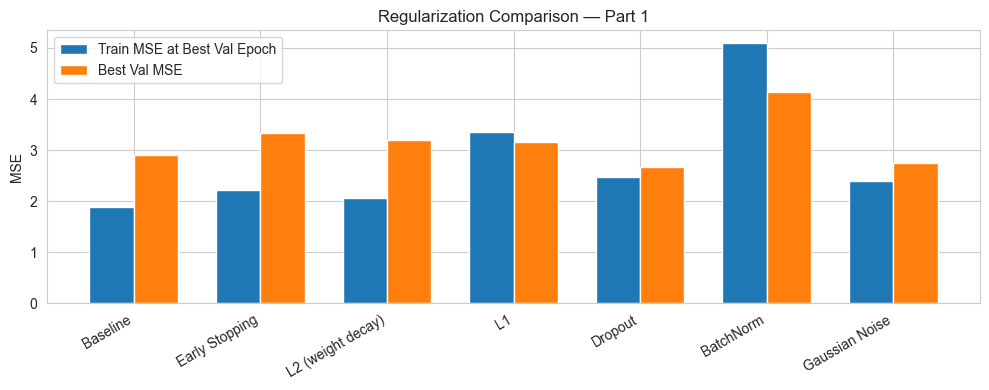

In [18]:
# Note: exact metrics can vary across runs and hardware (CPU vs GPU) due to nondeterminism.
results = {
    'Baseline':       history_base,
    'Early Stopping': history_es,
    'L2 (weight decay)': history_l2,
    'L1':             history_l1,
    'Dropout':        history_dropout,
    'BatchNorm':      history_bn,
    'Gaussian Noise': history_noise,
}

names = list(results.keys())
best_val  = [np.nanmin(h['val_loss']) for h in results.values()]
best_val_epoch = [np.nanargmin(h['val_loss']) for h in results.values()]
train_at_best = [h['loss'][e] for h, e in zip(results.values(), best_val_epoch)]

# --- Table ---
print(f"{'Method':<20s} {'Best Val MSE':>12s} {'Train at Best':>14s} {'Gap':>8s}")
print("-" * 58)
for name, bv, tb in zip(names, best_val, train_at_best):
    print(f"{name:<20s} {bv:12.4f} {tb:14.4f} {bv - tb:8.4f}")

# --- Bar chart ---
x = np.arange(len(names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(x - width/2, train_at_best, width, label='Train MSE at Best Val Epoch')
ax.bar(x + width/2, best_val, width, label='Best Val MSE')
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=30, ha='right')
ax.set_ylabel('MSE')
ax.set_title('Regularization Comparison — Part 1')
ax.legend()
plt.tight_layout()
plt.show()

## Part 2: Classification with Fashion-MNIST

Having seen regularization in the regression setting, we now apply these ideas to a classification task. We'll build an MLP classifier on Fashion-MNIST, observe overfitting with limited data, and then use data augmentation to improve generalization.

---

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a drop-in replacement for MNIST.

<img src="https://4.bp.blogspot.com/-OQZGt_5WqDo/Wa_Dfa4U15I/AAAAAAAAAUI/veRmAmUUKFA19dVw6XCOV2YLO6n-y_omwCLcBGAs/s400/out.jpg" width="400px" alt="Grid of Fashion-MNIST sample images showing 10 clothing categories: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boot" />

### DataLoaders (PyTorch)

We use `torchvision.datasets.FashionMNIST` with `transforms.Compose` and PyTorch DataLoaders. We'll take a small train/validation split for faster experimentation.

In [19]:
# Load Fashion-MNIST with normalization
mean, std = (0.2860,), (0.3530,)
base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

fashion_train = datasets.FashionMNIST(root='data', train=True, download=True, transform=base_transform)
fashion_test = datasets.FashionMNIST(root='data', train=False, download=True, transform=base_transform)

print(fashion_train, fashion_test)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.286,), std=(0.353,))
           ) Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.286,), std=(0.353,))
           )


In [20]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


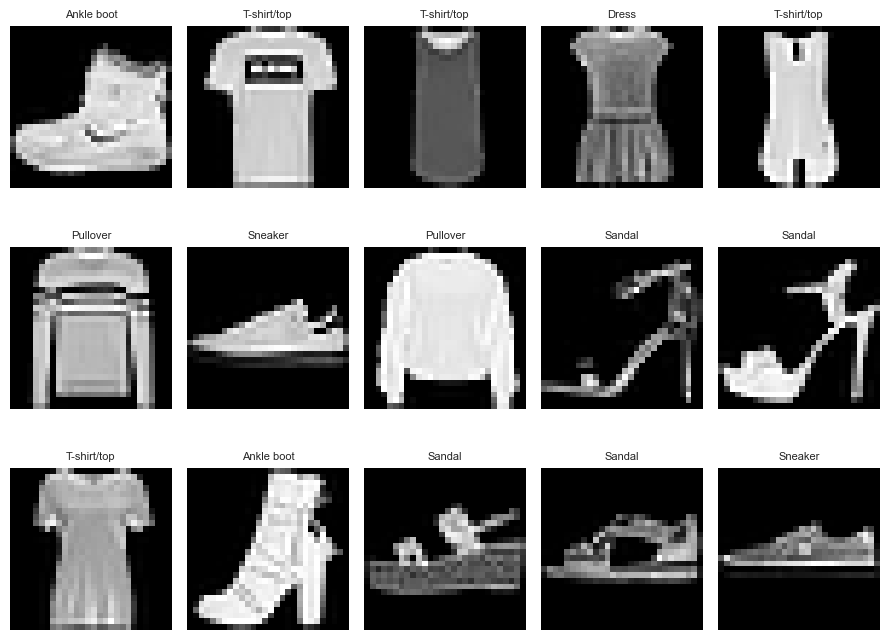

In [21]:
# Display a few examples (unnormalized for visualization)
fig, axs = plt.subplots(3, 5, figsize=(9, 7))
for i, ax in enumerate(axs.ravel()):
    image, label = fashion_train[i]
    image = image * std[0] + mean[0]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(labels[label], fontsize=8)
    ax.axis('off')
plt.tight_layout()

We will use PyTorch `Subset` objects to create train/validation/test splits without writing images to disk.

In [22]:
from torch.utils.data import Subset

# Reduce dataset sizes for faster experimentation
generator = torch.Generator().manual_seed(109)
train_size = 1200
val_size = 240
test_size = 1000

train_val_indices = torch.randperm(len(fashion_train), generator=generator)[:train_size + val_size]
train_indices = train_val_indices[:train_size].tolist()
val_indices = train_val_indices[train_size:].tolist()
test_indices = torch.randperm(len(fashion_test), generator=generator)[:test_size].tolist()

train_subset = Subset(fashion_train, train_indices)
val_subset = Subset(fashion_train, val_indices)
test_subset = Subset(fashion_test, test_indices)

In [23]:
# Create DataLoaders
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)

data_batch, labels_batch = next(iter(train_loader))
print('data batch shape:', data_batch.shape)
print('labels batch shape:', labels_batch.shape)

data batch shape: torch.Size([32, 1, 28, 28])
labels batch shape: torch.Size([32])


> **❓ Question 4: Subset Splits**
>
> 1. Why do we create separate train/validation/test subsets instead of reusing the full dataset?
> 2. How could class imbalance in a small subset affect validation accuracy?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. Each split serves a distinct purpose: **training data** is used to learn weights, **validation data** is used to tune hyperparameters (learning rate, regularization strength, when to stop), and **test data** provides an unbiased estimate of generalization. If we reused data across these roles, our estimates would be optimistically biased - we'd be evaluating on data the model has already seen or that influenced our choices. The test set should only be used once, after all tuning is complete, to get a fair measure of real-world performance.
>
> 2. When randomly sampling a small subset, some classes may end up over- or under-represented by chance. If the validation set has fewer examples of a difficult class, accuracy may appear artificially high. Conversely, if a rare class is over-represented, small improvements on that class can swing the overall metric. This makes validation accuracy a noisier signal for hyperparameter tuning. Stratified sampling (ensuring each class appears proportionally) can mitigate this, but with very small subsets, variance remains unavoidable.

</details>

### Build a Classifier

In [24]:
class FashionMLP(nn.Module):
    def __init__(self, input_dim=28*28, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [25]:
def train_classifier(model, train_loader, val_loader, optimizer, criterion, epochs=30, early_stopping=None):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
        train_loss /= len(train_loader.dataset)
        train_acc = correct / total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item() * xb.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == yb).sum().item()
                val_total += yb.size(0)
        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / val_total

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        if early_stopping and early_stopping.step(val_loss, model):
            break

    if early_stopping:
        early_stopping.restore(model)

    return history


def evaluate_classifier(model, loader, criterion):
    model.eval()
    loss_total = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss_total += loss.item() * xb.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return loss_total / len(loader.dataset), correct / total

In [26]:
torch.manual_seed(109)
model_cls = FashionMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cls.parameters(), lr=0.001)

history_cls = train_classifier(
    model_cls,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    epochs=30,
    early_stopping=EarlyStopping(patience=5)
)

In [27]:
train_loss, train_acc = evaluate_classifier(model_cls, train_loader, criterion)
val_loss, val_acc = evaluate_classifier(model_cls, val_loader, criterion)
test_loss, test_acc = evaluate_classifier(model_cls, test_loader, criterion)

print(f"Train — Loss: {train_loss:.4f}, Acc: {train_acc:.2f}")
print(f"Val   — Loss: {val_loss:.4f}, Acc: {val_acc:.2f}")
print(f"Test  — Loss: {test_loss:.4f}, Acc: {test_acc:.2f}")

Train — Loss: 0.0797, Acc: 0.99
Val   — Loss: 0.5258, Acc: 0.85
Test  — Loss: 0.6862, Acc: 0.78


Val Acc at last training epoch (before best-model restore): 0.81


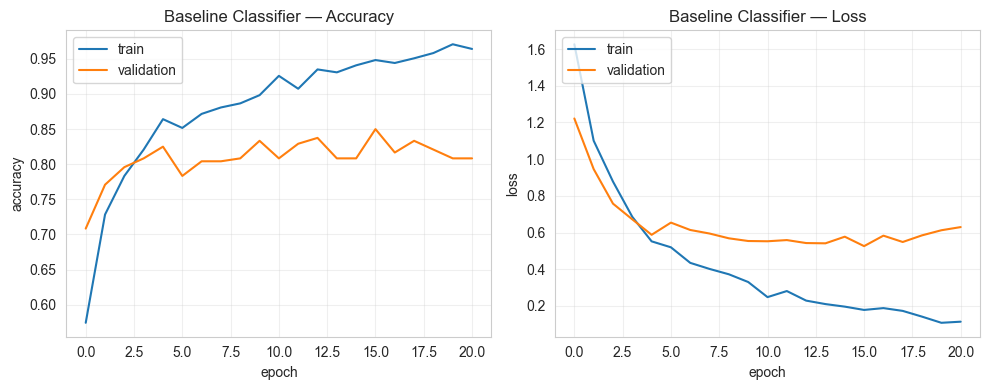

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
print(f"Val Acc at last training epoch (before best-model restore): {history_cls['val_accuracy'][-1]:.2f}")   
axs[0].plot(history_cls['accuracy'])
axs[0].plot(history_cls['val_accuracy'])
axs[0].set_title('Baseline Classifier — Accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].grid(True, alpha=0.3)
axs[0].legend(['train', 'validation'], loc='upper left')

axs[1].plot(history_cls['loss'])
axs[1].plot(history_cls['val_loss'])
axs[1].set_title('Baseline Classifier — Loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].grid(True, alpha=0.3)
axs[1].legend(['train', 'validation'], loc='upper left')
plt.tight_layout();

### Data Augmentation

In Part 1, we added Gaussian noise directly inside the model as a regularizer. For image data, we can go further — applying transformations that exploit known invariances. A T-shirt is still a T-shirt whether flipped horizontally or slightly rotated. By applying random transforms on-the-fly, the model sees a different variation of each image every epoch, even though the dataset itself remains 1,200 samples. Below we combine random flips, small rotations, and Gaussian noise as a `torchvision` transform pipeline.

In [29]:
class AddGaussianNoise:
    def __init__(self, std=0.05):
        self.std = std

    def __call__(self, tensor):
        return torch.clamp(tensor + torch.randn_like(tensor) * self.std, 0.0, 1.0)

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  #Default probability is 0.5
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    AddGaussianNoise(0.05),
    transforms.Normalize(mean, std)
])

fashion_train_aug = datasets.FashionMNIST(root='data', train=True, download=False, transform=augment_transform)
train_subset_aug = Subset(fashion_train_aug, train_indices)
train_loader_aug = torch.utils.data.DataLoader(train_subset_aug, batch_size=batch_size, shuffle=True)

> **❓ Question 5: Choosing Augmentations**
>
> Not all augmentations are appropriate for every dataset. Consider the transforms we used: `RandomHorizontalFlip`, `RandomRotation(10)`, and `AddGaussianNoise`.
>
> 1. Why is `RandomHorizontalFlip` a reasonable augmentation for Fashion-MNIST? For which classes (if any) might it *not* preserve the label?
> 2. Why do we limit rotation to just 10 degrees? What could go wrong with larger rotations (e.g., 90°)?
> 3. We did **not** include `RandomVerticalFlip`. Why would vertical flips be a bad augmentation for clothing images?
> 4. If you were working with a medical imaging dataset (e.g., chest X-rays), which of these augmentations would still be appropriate and which would not?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. Most clothing items look plausible when mirrored left-to-right — a horizontally flipped sneaker is still a valid sneaker. For symmetric classes (T-shirt, Pullover, Coat) it's essentially a no-op. Some items with asymmetric features (e.g., a Bag with a side clasp) could look slightly different flipped, but the label stays valid.
>
> 2. Small rotations simulate natural variation in how items are photographed or worn. At 90°, a T-shirt becomes sideways - it no longer looks like a typical T-shirt image, which would add noisy/misleading training signal. The augmentation should stay within the range of plausible real-world variation.
>
> 3. Clothing is almost never seen upside-down. An upside-down ankle boot doesn't resemble any real training or test example, so vertical flips would introduce unrealistic samples that could hurt generalization rather than help it.
>
> 4. Horizontal flips may or may not be appropriate depending on anatomy (chest X-rays are roughly symmetric, so flips are often fine; but for laterality-sensitive tasks they would be harmful). Small rotations are generally safe. Gaussian noise can simulate sensor noise and is usually appropriate. An augmentation is valid only if the transformed image could plausibly appear in the real data with the same label.

</details>

In [30]:
torch.manual_seed(109)
model_cls_aug = FashionMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cls_aug.parameters(), lr=0.001)

history_aug = train_classifier(
    model_cls_aug,
    train_loader_aug,
    val_loader,
    optimizer,
    criterion,
    epochs=60,
    early_stopping=EarlyStopping(patience=10)
)

Final epoch val Acc: 0.84
Best epoch val Acc: 0.85


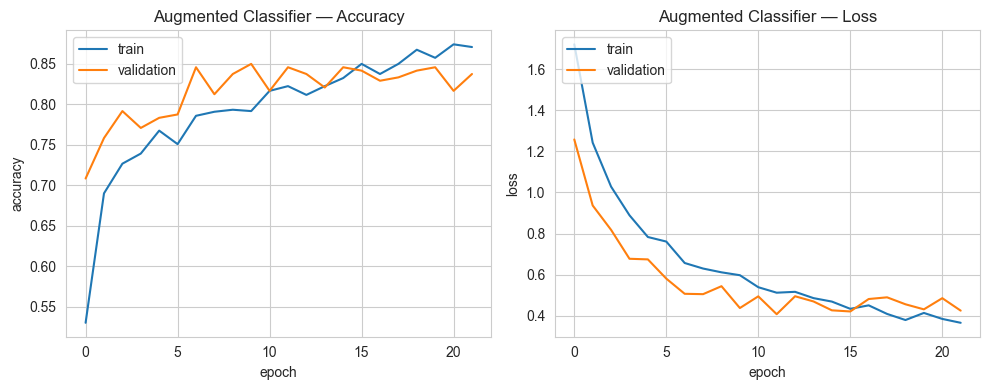

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
print(f"Final epoch val Acc: {history_aug['val_accuracy'][-1]:.2f}")
print(f"Best epoch val Acc: {max(history_aug['val_accuracy']):.2f}")

axs[0].plot(history_aug['accuracy'])
axs[0].plot(history_aug['val_accuracy'])
axs[0].set_title('Augmented Classifier — Accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'validation'], loc='upper left')

axs[1].plot(history_aug['loss'])
axs[1].plot(history_aug['val_loss'])
axs[1].set_title('Augmented Classifier — Loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'validation'], loc='upper left')
plt.tight_layout();

In [32]:
train_loss, train_acc = evaluate_classifier(model_cls_aug, train_loader, criterion)
val_loss, val_acc = evaluate_classifier(model_cls_aug, val_loader, criterion)
test_loss, test_acc = evaluate_classifier(model_cls_aug, test_loader, criterion)

print(f"Train — Loss: {train_loss:.4f}, Acc: {train_acc:.2f}")
print(f"Val   — Loss: {val_loss:.4f}, Acc: {val_acc:.2f}")
print(f"Test  — Loss: {test_loss:.4f}, Acc: {test_acc:.2f}")

Train — Loss: 0.3577, Acc: 0.87
Val   — Loss: 0.4081, Acc: 0.85
Test  — Loss: 0.6030, Acc: 0.80


**Results comparison:** Augmentation improved validation accuracy over the baseline on our small 1,200-sample training set, while test accuracy remained similar. With only 1,000 test samples, a few points of difference can be noise, and the validation split comes from the same `fashion_train` pool, so gains may not transfer to the separate test set. Always rely on a truly held-out test set and avoid over-interpreting small differences.

Note: exact metrics can vary across runs and hardware (CPU vs GPU) due to nondeterminism.

> **❓ Question 6: Model Layer vs. Data Transform for Noise**
>
> In Part 1 we added Gaussian noise as a **model layer** (`GaussianNoise(nn.Module)`), while in Part 2 we added it as a **data transform** (`AddGaussianNoise` in `transforms.Compose`). Both inject random noise during training to regularize the model.
>
> 1. At what point in the pipeline does noise get applied in each approach? How does this affect what the noise "means" (pixel space vs. normalized space)?
> 2. What are the trade-offs of each approach? When might you prefer one over the other?
> 3. The `AddGaussianNoise` transform clamps values to [0, 1]. Why is this necessary here but not in the `GaussianNoise` module?


<details>
<summary><em>Click to reveal answer</em></summary>

> 1. **Data transform (Part 2):** Noise is applied in the data loading pipeline, *after* `ToTensor()` (pixel space [0, 1]) but *before* `Normalize()`. So the noise is in raw pixel space — a std of 0.05 means ~5% of the pixel range. **Model layer (Part 1):** Noise is applied inside the model's `forward()` pass, so it acts on already-normalized inputs. The noise magnitude is relative to the normalized feature scale, not raw pixel values.
>
> 2. **Data transform pros:** Composes naturally with other image augmentations (flips, rotations, crops); keeps the model architecture clean; noise parameters are part of the data pipeline config. **Model layer pros:** Automatically disabled at eval time via `model.eval()` (no need to manage separate train/test transforms); the noise is always in the same space as the model's inputs; can be placed between any layers (not just at the input). A model layer is more convenient when you don't have a separate augmented data pipeline, or when you want noise injected at intermediate layers.
>
> 3. The transform operates in pixel space [0, 1], where values outside this range are physically meaningless (you can't have negative pixel intensity). Clamping keeps values valid before normalization. The `GaussianNoise` module operates in normalized space, where values are already unbounded (normalization maps [0, 1] to roughly [-0.81, 2.02]), so clamping would be inappropriate — it would distort the learned distribution.

</details>

---

## 🏋️ TEAM ACTIVITY: Fashion-MNIST Regularization

Try improving validation accuracy beyond 83% without changing the overall network depth. Consider tuning dropout rates, batch normalization placement, optimizers, and augmentation settings. Track your best configuration.

---

**Define an enhanced model with dropout**

Create a modified `FashionMLP` that adds dropout layers between the hidden layers. Keep the same layer sizes (256 → 128 → 64 → 32) but add `nn.Dropout` after the first two ReLU activations.

**Hint:** A dropout rate of 0.2 provides regularization without over-constraining the model. Don't add dropout to every layer.

In [33]:
# your code here
# BEGIN SOLUTION
class FashionMLPRegularized(nn.Module):
    def __init__(self, input_dim=28*28, num_classes=10, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.net(x)
# END SOLUTION

**Create augmentation with small translations**

The baseline augmentation already includes flips, rotation, and noise. Add small random translations via `RandomAffine` to simulate slightly shifted images.

**Hint:** Keep translations small (5% of image size) to avoid shifting important features out of frame.

In [34]:
# your code here
# BEGIN SOLUTION
augment_transform_v2 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Small shifts
    transforms.ToTensor(),
    AddGaussianNoise(0.05),
    transforms.Normalize(mean, std)
])

fashion_train_aug_v2 = datasets.FashionMNIST(root='data', train=True, download=False, transform=augment_transform_v2)
train_subset_aug_v2 = Subset(fashion_train_aug_v2, train_indices)
train_loader_aug_v2 = torch.utils.data.DataLoader(train_subset_aug_v2, batch_size=32, shuffle=True)
# END SOLUTION

**Train and evaluate**

Train your regularized model. The dropout already provides regularization, so we don't need heavy weight decay.

**Hint:** Standard Adam with `lr=0.001` works well with dropout.

In [35]:
# your code here
# BEGIN SOLUTION
torch.manual_seed(109)
model_team = FashionMLPRegularized(dropout=0.2).to(device)
optimizer = optim.Adam(model_team.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

history_team = train_classifier(
    model_team,
    train_loader_aug_v2,
    val_loader,
    optimizer,
    criterion,
    epochs=100,
    early_stopping=EarlyStopping(patience=10)
)

# Evaluate
train_loss, train_acc = evaluate_classifier(model_team, train_loader, criterion)
val_loss, val_acc = evaluate_classifier(model_team, val_loader, criterion)
test_loss, test_acc = evaluate_classifier(model_team, test_loader, criterion)

print(f"Train — Loss: {train_loss:.4f}, Acc: {train_acc:.2f}")
print(f"Val   — Loss: {val_loss:.4f}, Acc: {val_acc:.2f}")
print(f"Test  — Loss: {test_loss:.4f}, Acc: {test_acc:.2f}")
# END SOLUTION

Train — Loss: 0.3591, Acc: 0.87
Val   — Loss: 0.3894, Acc: 0.85
Test  — Loss: 0.6393, Acc: 0.77


**Plot training curves**

Plot the accuracy and loss curves for your regularized model. Compare the gap between training and validation — is it smaller than the baseline?

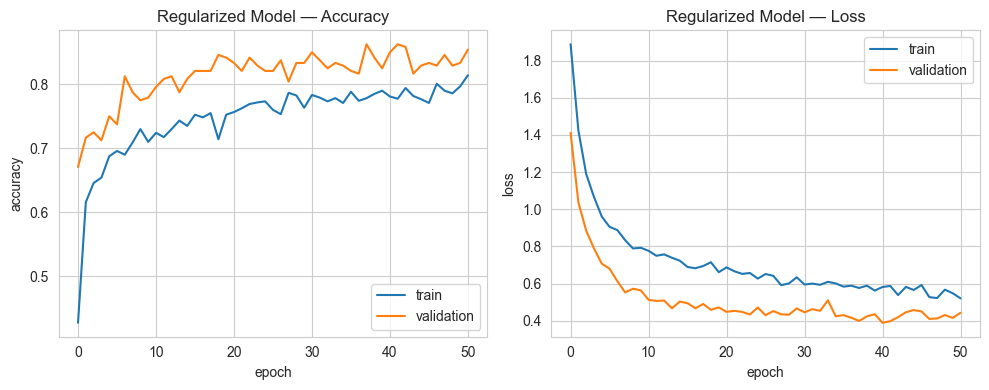

In [36]:
# your code here
# BEGIN SOLUTION
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(history_team['accuracy'], label='train')
axs[0].plot(history_team['val_accuracy'], label='validation')
axs[0].set_title('Regularized Model — Accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')
axs[0].legend()

axs[1].plot(history_team['loss'], label='train')
axs[1].plot(history_team['val_loss'], label='validation')
axs[1].set_title('Regularized Model — Loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend()

plt.tight_layout()
# END SOLUTION

**End of team activity**